In [1013]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

from statsforecast import StatsForecast
from statsforecast.models import Naive, SeasonalNaive, SeasonalWindowAverage, AutoARIMA

In [1014]:
url = 'dados_ibovespa.csv'
df = pd.read_csv(url)
df.head()

,Data,Último,Abertura,Máxima,Mínima,Vol.,Var%
0,09.07.2025,137.481,139.303,139.331,137.299,"7,58B","-1,31%"
1,08.07.2025,139.303,139.491,139.591,138.770,"6,75B","-0,13%"
2,07.07.2025,139.490,141.265,141.342,139.295,"6,12B","-1,26%"
3,04.07.2025,141.264,140.928,141.564,140.597,"3,31B","0,24%"
4,03.07.2025,140.928,139.051,141.304,139.051,"6,08B","1,35%"


Estamos verificando se existe dados nulos na nossa base de dados.

In [1015]:
df.isnull().sum()

Data        0
Último      0
Abertura    0
Máxima      0
Mínima      0
Vol.        1
Var%        0
dtype: int64

Aqui damos um **info()** para entendermos um pouco mais sobre os tipo de variáveis que estamos trabalhando.

In [1016]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4953 entries, 0 to 4952
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Data      4953 non-null   object 
 1   Último    4953 non-null   float64
 2   Abertura  4953 non-null   float64
 3   Máxima    4953 non-null   float64
 4   Mínima    4953 non-null   float64
 5   Vol.      4952 non-null   object 
 6   Var%      4953 non-null   object 
dtypes: float64(4), object(3)
memory usage: 271.0+ KB


Anteriormente, notamos que o tipo do campo **"Data"** que iremos utilizar esta como object(string), sendo assim será necessário transforma-lo em tipo data. 

In [1017]:
df['Data'] = pd.to_datetime(df['Data'], dayfirst=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4953 entries, 0 to 4952
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Data      4953 non-null   datetime64[ns]
 1   Último    4953 non-null   float64       
 2   Abertura  4953 non-null   float64       
 3   Máxima    4953 non-null   float64       
 4   Mínima    4953 non-null   float64       
 5   Vol.      4952 non-null   object        
 6   Var%      4953 non-null   object        
dtypes: datetime64[ns](1), float64(4), object(2)
memory usage: 271.0+ KB


Já temos nossa coluna de Data ajustada de maneira correta, agora precisamos criar uma coluna categorica, do qual escolhi categorizar meus dados de acordo com os dias da semana.

In [1018]:
df['serie_id'] = 'ibovespa'

In [1019]:
df

,Data,Último,Abertura,Máxima,Mínima,Vol.,Var%,serie_id
0,2025-07-09,137.481,139.303,139.331,137.299,"7,58B","-1,31%",ibovespa
1,2025-07-08,139.303,139.491,139.591,138.770,"6,75B","-0,13%",ibovespa
2,2025-07-07,139.490,141.265,141.342,139.295,"6,12B","-1,26%",ibovespa
3,2025-07-04,141.264,140.928,141.564,140.597,"3,31B","0,24%",ibovespa
4,2025-07-03,140.928,139.051,141.304,139.051,"6,08B","1,35%",ibovespa
...,...,...,...,...,...,...,...,...
4948,2005-07-15,25.222,25.916,25.916,25.222,"72,88M","-2,69%",ibovespa
4949,2005-07-14,25.920,25.859,26.142,25.725,"113,35M","0,25%",ibovespa
4950,2005-07-13,25.856,25.557,26.043,25.557,"107,28M","1,25%",ibovespa
4951,2005-07-12,25.536,25.027,25.576,24.932,"94,91M","2,08%",ibovespa


Agora iremos analisar nossa base de dados de acordo com os parâmetros de uma Time Series.

Agora iremos renomer as nossas colunas, para seguir o padrão de modelos de time series 

In [1020]:
df = df.rename(columns={'Data': 'ds', 'Último': 'y', 'serie_id': 'unique_id'})

df.head()

,ds,y,Abertura,Máxima,Mínima,Vol.,Var%,unique_id
0,2025-07-09,137.481,139.303,139.331,137.299,"7,58B","-1,31%",ibovespa
1,2025-07-08,139.303,139.491,139.591,138.770,"6,75B","-0,13%",ibovespa
2,2025-07-07,139.490,141.265,141.342,139.295,"6,12B","-1,26%",ibovespa
3,2025-07-04,141.264,140.928,141.564,140.597,"3,31B","0,24%",ibovespa
4,2025-07-03,140.928,139.051,141.304,139.051,"6,08B","1,35%",ibovespa


In [1021]:
df = df.drop(columns=['Abertura', 'Máxima', 'Mínima', 'Vol.', 'Var%'])

df

,ds,y,unique_id
0,2025-07-09,137.481,ibovespa
1,2025-07-08,139.303,ibovespa
2,2025-07-07,139.490,ibovespa
3,2025-07-04,141.264,ibovespa
4,2025-07-03,140.928,ibovespa
...,...,...,...
4948,2005-07-15,25.222,ibovespa
4949,2005-07-14,25.920,ibovespa
4950,2005-07-13,25.856,ibovespa
4951,2005-07-12,25.536,ibovespa


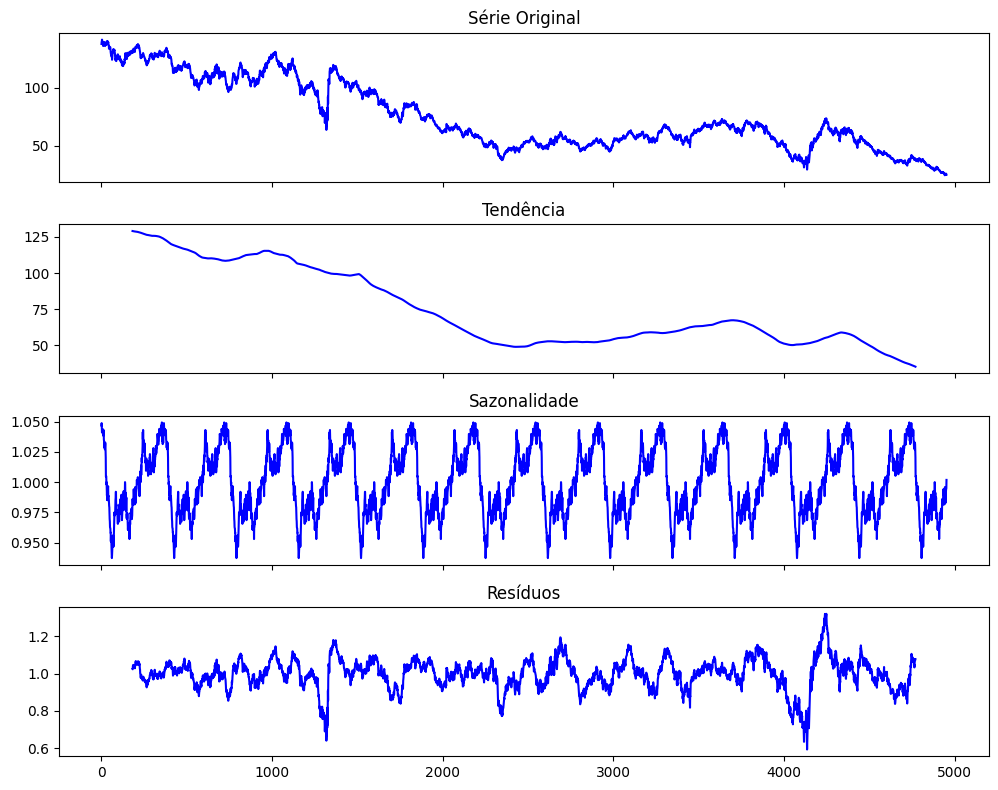

In [1022]:
result = seasonal_decompose(df["y"], model="multiplicative", period=365)
fig, axs = plt.subplots(4, 1, figsize=(10, 8), sharex=True)

axs[0].plot(result.observed, color='blue')
axs[0].set_title('Série Original')

axs[1].plot(result.trend, color='blue')
axs[1].set_title('Tendência')

axs[2].plot(result.seasonal, color='blue')
axs[2].set_title('Sazonalidade')

axs[3].plot(result.resid, color='blue')
axs[3].set_title('Resíduos')

plt.tight_layout()
plt.show()

Agora iremos fazer um teste para ver se a nossa base é ou não estacionária.

In [1023]:
X = df.y.values

result = adfuller(X)
print('Teste ADF: %f' % result[0])
print('p-value: %f' % result[1])
print('Valores Críticos:')

for key, value in result[4].items():
    print(f'   {key}: {value}')

Teste ADF: -1.641246
p-value: 0.461610
Valores Críticos:
   1%: -3.431673361342282
   5%: -2.8621247811548693
   10%: -2.5670812799683316


De acordo com os resultados obtidos no teste ADF, conseguimos concluir que a nossa  time series, não é estacionária.

Agora iremos tentar deixar nossa serie estacionária utilizando a tecnica de calcular a diferença entre valores consecutivos.

In [1024]:
df['y_diff'] = df['y'].diff()

In [1025]:
X_diff = df['y_diff'].dropna()

In [1026]:
result = adfuller(X_diff)
print('ADF após diferenciação: %f' % result[0])
print('p-value: %f' % result[1])
print('Valores Críticos:')
for key, value in result[4].items():
    print(f'   {key}: {value}')

ADF após diferenciação: -23.842915
p-value: 0.000000
Valores Críticos:
   1%: -3.431673361342282
   5%: -2.8621247811548693
   10%: -2.5670812799683316


Agora iremos separar em um df estacionário e outro não estacionário para podermos utiliza-los posteriormente nos modelos, e ver a diferença entre eles.

In [1027]:
df_nao_estacionario = df.copy()
df_nao_estacionario = df_nao_estacionario[['ds' ,'y','unique_id' ]]

In [1028]:
df_nao_estacionario

,ds,y,unique_id
0,2025-07-09,137.481,ibovespa
1,2025-07-08,139.303,ibovespa
2,2025-07-07,139.490,ibovespa
3,2025-07-04,141.264,ibovespa
4,2025-07-03,140.928,ibovespa
...,...,...,...
4948,2005-07-15,25.222,ibovespa
4949,2005-07-14,25.920,ibovespa
4950,2005-07-13,25.856,ibovespa
4951,2005-07-12,25.536,ibovespa


In [1029]:
X = df_nao_estacionario.y.values

result = adfuller(X)
print('Teste ADF: %f' % result[0])
print('p-value: %f' % result[1])
print('Valores Críticos:')

for key, value in result[4].items():
    print(f'   {key}: {value}')

Teste ADF: -1.641246
p-value: 0.461610
Valores Críticos:
   1%: -3.431673361342282
   5%: -2.8621247811548693
   10%: -2.5670812799683316


In [1030]:
df_estacionario = df.copy()
df_estacionario['y'] = df_estacionario['y'].diff()
df_estacionario = df_estacionario.dropna()

In [1031]:
df_estacionario = df_estacionario[['ds','y_diff', 'unique_id']]
df_estacionario.rename(columns={ 'y_diff': 'y'}, inplace=True)
df_estacionario

,ds,y,unique_id
1,2025-07-08,1.822,ibovespa
2,2025-07-07,0.187,ibovespa
3,2025-07-04,1.774,ibovespa
4,2025-07-03,-0.336,ibovespa
5,2025-07-02,-1.877,ibovespa
...,...,...,...
4948,2005-07-15,-0.099,ibovespa
4949,2005-07-14,0.698,ibovespa
4950,2005-07-13,-0.064,ibovespa
4951,2005-07-12,-0.320,ibovespa


In [1032]:
X = df_estacionario.y.values

result = adfuller(X)
print('Teste ADF: %f' % result[0])
print('p-value: %f' % result[1])
print('Valores Críticos:')

for key, value in result[4].items():
    print(f'   {key}: {value}')

Teste ADF: -23.842915
p-value: 0.000000
Valores Críticos:
   1%: -3.431673361342282
   5%: -2.8621247811548693
   10%: -2.5670812799683316


## Preparando nossa base para os modelos

In [1033]:
df_nao_estacionario.head()

,ds,y,unique_id
0,2025-07-09,137.481,ibovespa
1,2025-07-08,139.303,ibovespa
2,2025-07-07,139.490,ibovespa
3,2025-07-04,141.264,ibovespa
4,2025-07-03,140.928,ibovespa


In [1034]:
df_nao_estacionario.tail()

,ds,y,unique_id
4948,2005-07-15,25.222,ibovespa
4949,2005-07-14,25.920,ibovespa
4950,2005-07-13,25.856,ibovespa
4951,2005-07-12,25.536,ibovespa
4952,2005-07-11,25.016,ibovespa


Aqui estamos separando nossa base de dados de 25 Anos para o treino, e 30 dias úteis para treino.

base não estacionária.

In [1035]:
treino_nao_estacionaria = df.loc[(df_nao_estacionario['ds']  >= '2000-05-09') & (df_nao_estacionario['ds'] < '2025-05-08')]

valid_nao_estacionaria = df_nao_estacionario[(df_nao_estacionario['ds'] >= '2025-05-09') & (df_nao_estacionario['ds'] <= '2025-06-20')]

h = valid_nao_estacionaria['ds'].nunique()

h

30

In [1036]:
treino_nao_estacionaria = treino_nao_estacionaria[['ds', 'y', 'unique_id']]

In [1037]:
valid_nao_estacionaria.head()

,ds,y,unique_id
13,2025-06-20,137.116,ibovespa
14,2025-06-18,138.717,ibovespa
15,2025-06-17,138.840,ibovespa
16,2025-06-16,139.256,ibovespa
17,2025-06-13,137.213,ibovespa


base estacionária.

In [1038]:
df_estacionario.head()

,ds,y,unique_id
1,2025-07-08,1.822,ibovespa
2,2025-07-07,0.187,ibovespa
3,2025-07-04,1.774,ibovespa
4,2025-07-03,-0.336,ibovespa
5,2025-07-02,-1.877,ibovespa


In [1039]:
treino_estacionaria = df_estacionario.loc[(df_estacionario['ds']  >= '2000-05-09') & (df_estacionario['ds'] < '2025-05-08')]

valid_estacionaria = df_estacionario[(df_estacionario['ds'] >= '2025-05-09') & (df_estacionario['ds'] <= '2025-06-20')]

h = valid_estacionaria['ds'].nunique()

h

30

In [1040]:
treino_estacionaria

,ds,y,unique_id
44,2025-05-07,-2.834,ibovespa
45,2025-05-06,0.118,ibovespa
46,2025-05-05,-0.025,ibovespa
47,2025-05-02,1.643,ibovespa
48,2025-04-30,-0.067,ibovespa
...,...,...,...
4948,2005-07-15,-0.099,ibovespa
4949,2005-07-14,0.698,ibovespa
4950,2005-07-13,-0.064,ibovespa
4951,2005-07-12,-0.320,ibovespa


Agora iremos montar nossa função wmape para visualizarmos quanto os modelos estão acertando ou errando.

In [1041]:
def wmape(y_true, y_pred):
    return np.abs(y_true - y_pred).sum() / np.abs(y_true).sum()

# Criando Modelo

In [1042]:
valid_nao_estacionaria.head()

,ds,y,unique_id
13,2025-06-20,137.116,ibovespa
14,2025-06-18,138.717,ibovespa
15,2025-06-17,138.840,ibovespa
16,2025-06-16,139.256,ibovespa
17,2025-06-13,137.213,ibovespa


In [1043]:
model_nao_estacionario = StatsForecast(models=[Naive()], freq='D', n_jobs=-1)

model_nao_estacionario.fit(treino_nao_estacionaria)

forecast_df_nao_estacionario = model_nao_estacionario.predict(h=h, level=[90])

forecast_df_nao_estacionario = forecast_df_nao_estacionario.reset_index().merge(valid_nao_estacionaria, on=['ds', 'unique_id'], how='left')

forecast_df_nao_estacionario = forecast_df_nao_estacionario.dropna(subset=["y"])

wmape1 = wmape(forecast_df_nao_estacionario['y'].values, forecast_df_nao_estacionario['Naive'].values)

print(f'WMAPE: {wmape1: .2%}')

WMAPE:  3.32%


fazendo o modelo com o nosso df_estacionario

In [1054]:
model_estacionario = StatsForecast(models=[Naive()], freq='D', n_jobs=-1)

model_estacionario.fit(treino_estacionaria)

forecast_df_estacionario = model_estacionario.predict(h=h, level=[90])

forecast_df_estacionario = forecast_df_estacionario.reset_index().merge(valid_estacionaria, on=['ds', 'unique_id'], how='left')

forecast_df_estacionario = forecast_df_estacionario.dropna(subset=["y"])

wmape1 = wmape(forecast_df_estacionario['y'].values, forecast_df_estacionario['Naive'].values)

print(f'WMAPE: {wmape1: .2%}')

WMAPE:  390.79%


## Modelo de sazonalidade

In [1055]:
model_s_nao_estacionario = StatsForecast(models=[SeasonalNaive(season_length=7)], freq='D', n_jobs=-1)

model_s_nao_estacionario.fit(treino_nao_estacionaria)

forecast_df_s_nao_estacionario = model_s_nao_estacionario.predict(h=h, level=[90])

forecast_df_s_nao_estacionario = forecast_df_s_nao_estacionario.reset_index().merge(valid_nao_estacionaria, on=['ds', 'unique_id'], how='left')

forecast_df_s_nao_estacionario = forecast_df_s_nao_estacionario.dropna(subset=["y"])

wmape2 = wmape(forecast_df_s_nao_estacionario['y'].values, forecast_df_s_nao_estacionario['SeasonalNaive'].values)

print(f'WMAPE: {wmape2: .2%}')

WMAPE:  2.77%


In [1056]:
model_s_estacionario = StatsForecast(models=[SeasonalNaive(season_length=7)], freq='D', n_jobs=-1)

model_s_estacionario.fit(treino_estacionaria)

forecast_df_s_estacionario = model_s_estacionario.predict(h=h, level=[90])

forecast_df_s_estacionario = forecast_df_s_estacionario.reset_index().merge(valid_estacionaria, on=['ds', 'unique_id'], how='left')

forecast_df_s_estacionario = forecast_df_s_estacionario.dropna(subset=["y"])

wmape2 = wmape(forecast_df_s_estacionario['y'].values, forecast_df_s_estacionario['SeasonalNaive'].values)

print(f'WMAPE: {wmape2: .2%}')

WMAPE:  159.09%


## Modelo de sazonalidade junto com a média model

In [1057]:

model_sm_nao_estacionaria = StatsForecast(models=[SeasonalWindowAverage(season_length=7, window_size=2)], freq='D', n_jobs=-1)

model_sm_nao_estacionaria.fit(treino_nao_estacionaria)

forecast_df_sm_nao_estacionaria = model_sm_nao_estacionaria.predict(h=h)

forecast_df_sm_nao_estacionaria = forecast_df_sm_nao_estacionaria.reset_index().merge(valid_nao_estacionaria, on=['ds', 'unique_id'], how='left')

forecast_df_sm_nao_estacionaria = forecast_df_sm_nao_estacionaria.dropna(subset=["y"])

wmape3 = wmape(forecast_df_sm_nao_estacionaria['y'].values, forecast_df_sm_nao_estacionaria['SeasWA'].values)

print(f'WMAPE: {wmape3: .2%}')

WMAPE:  3.68%


In [1058]:

model_sm_estacionaria = StatsForecast(models=[SeasonalWindowAverage(season_length=7, window_size=2)], freq='D', n_jobs=-1)

model_sm_estacionaria.fit(treino_estacionaria)

forecast_df_sm_estacionaria = model_sm_estacionaria.predict(h=h)

forecast_df_sm_estacionaria = forecast_df_sm_estacionaria.reset_index().merge(valid_estacionaria, on=['ds', 'unique_id'], how='left')

forecast_df_sm_estacionaria = forecast_df_sm_estacionaria.dropna(subset=["y"])

wmape3 = wmape(forecast_df_sm_estacionaria['y'].values, forecast_df_sm_estacionaria['SeasWA'].values)

print(f'WMAPE: {wmape3: .2%}')

WMAPE:  125.58%


## Modelo ARIMA

In [1059]:

model_a_nao_estacionaria = StatsForecast(models=[AutoARIMA(season_length=7)], freq='D', n_jobs=-1)

model_a_nao_estacionaria.fit(treino_nao_estacionaria)

forecast_df_a_nao_estacionaria = model_a_nao_estacionaria.predict(h=h, level=[90])

forecast_df_a_nao_estacionaria = forecast_df_a_nao_estacionaria.reset_index().merge(valid_nao_estacionaria, on=['ds', 'unique_id'], how='left')

forecast_df_a_nao_estacionaria = forecast_df_a_nao_estacionaria.dropna(subset=["y"])

wmape4 = wmape(forecast_df_a_nao_estacionaria['y'].values, forecast_df_a_nao_estacionaria['AutoARIMA'].values)

print(f'WMAPE: {wmape4: .2%}')

WMAPE:  3.37%


In [1050]:

model_a_estacionaria = StatsForecast(models=[AutoARIMA(season_length=7)], freq='D', n_jobs=-1)

model_a_estacionaria.fit(treino_estacionaria)

forecast_df_a_estacionaria = model_a_estacionaria.predict(h=h, level=[90])

forecast_df_a_estacionaria = forecast_df_a_estacionaria.reset_index().merge(valid_estacionaria, on=['ds', 'unique_id'], how='left')

forecast_df_a_estacionaria = forecast_df_a_estacionaria.dropna(subset=["y"])

wmape4 = wmape(forecast_df_a_estacionaria['y'].values, forecast_df_a_estacionaria['AutoARIMA'].values)

print(f'WMAPE: {wmape4: .2%}')

WMAPE:  98.73%
